In [1]:
'''
Notes for revamping these weekly pre gw analyses

- use per game stats rather than per 90. i believe per 90 is a poor indicator of performance for fpl
- change percent of season played to minutes/MP, as in divide minutes by 90*(# of matches player played > 0 minutes). paints a better picture of the minutes a player gets for games they aren't
missing due to injury

'''

"\nNotes for revamping these weekly pre gw analyses\n\n- use per game stats rather than per 90. i believe per 90 is a poor indicator of performance for fpl\n- change percent of season played to minutes/MP, as in divide minutes by 90*(# of matches player played > 0 minutes). paints a better picture of the minutes a player gets for games they aren't\nmissing due to injury\n\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from help_functions import fpl_functions as fpl
pd.options.mode.chained_assignment = None
sns.set_theme()

In [3]:
GAMEWEEKS_PLAYED = 8

In [4]:
df = pd.read_excel('../data/players_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))
fixtures = pd.read_excel('../data/fixtures.xlsx')
my_team = pd.read_excel('../data/my_team_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))

In [5]:
df.loc[df['position'] == 'Goalkeeper'].groupby('team')['expected_goals_conceded'].sum().sort_values()

team
Liverpool          5.95
Bournemouth        6.88
Aston Villa        8.67
Spurs              8.68
Nott'm Forest      8.70
Man City           8.78
Chelsea            9.66
Fulham             9.84
Newcastle         11.24
Crystal Palace    12.09
Arsenal           12.18
Man Utd           12.26
West Ham          13.05
Everton           13.11
Brighton          13.39
Brentford         14.45
Wolves            15.19
Leicester         17.12
Southampton       17.26
Ipswich           17.44
Name: expected_goals_conceded, dtype: float64

In [6]:
#since the consideration is dropping saka, let's include him (he's currently flagged) into the analysis
#df.drop(df[df['status'].isin(['d', 'i', 's', 'u'])].index, inplace=True)
df = df.drop(df[df['minutes'] == 0].index)

df['now_cost'] = df['now_cost']/10

#create points per million (cost) column (ppm)
df['ppm'] = round(df['total_points']/df['now_cost'], 2)

df['goal_involvements'] = df['goals_scored'] + df['assists']
#create expected goals and goal involvements vs actual goals and goal involvements columns
df['g_vs_xg'] = df['goals_scored'] - df['expected_goals']
df['gi_vs_xgi'] = df['goal_involvements'] - df['expected_goal_involvements']

df['points_per_minute'] = df['total_points']/df['minutes']

df['gc_vs_xgc'] = df['goals_conceded'] - df['expected_goals_conceded']

df['percent_of_season_played'] = np.round(df['minutes']/(GAMEWEEKS_PLAYED*90) * 100, 2)
#drop players who've played less than half the season up until now
df = df.drop(df[df['percent_of_season_played'] < 50].index)

#expected goal involvements per million; could this be a good way to determine which players are "undervalued"?
df['xgi_pm'] = round(df['expected_goal_involvements']/df['now_cost'], 2)
df['xg_pm'] = round(df['expected_goals']/df['now_cost'], 2)
df['xa_pm'] = round(df['expected_assists']/df['now_cost'], 2)

In [7]:
fixtures_going_forward = fixtures.loc[fixtures['Gameweek'] > GAMEWEEKS_PLAYED]

df['next_match'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED+1)[['opponent', 'h_or_a']].iloc[-1]))
df['next_5_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+5)['FDR']))
#df['past_3_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED)['FDR']))
df['next_5_avg_FDRs'] = df['next_5_FDRs'].apply(lambda x: np.round(np.mean(x), 2))
#df['past_3_avg_FDRs'] = df['past_3_FDRs'].apply(lambda x: np.mean(x))

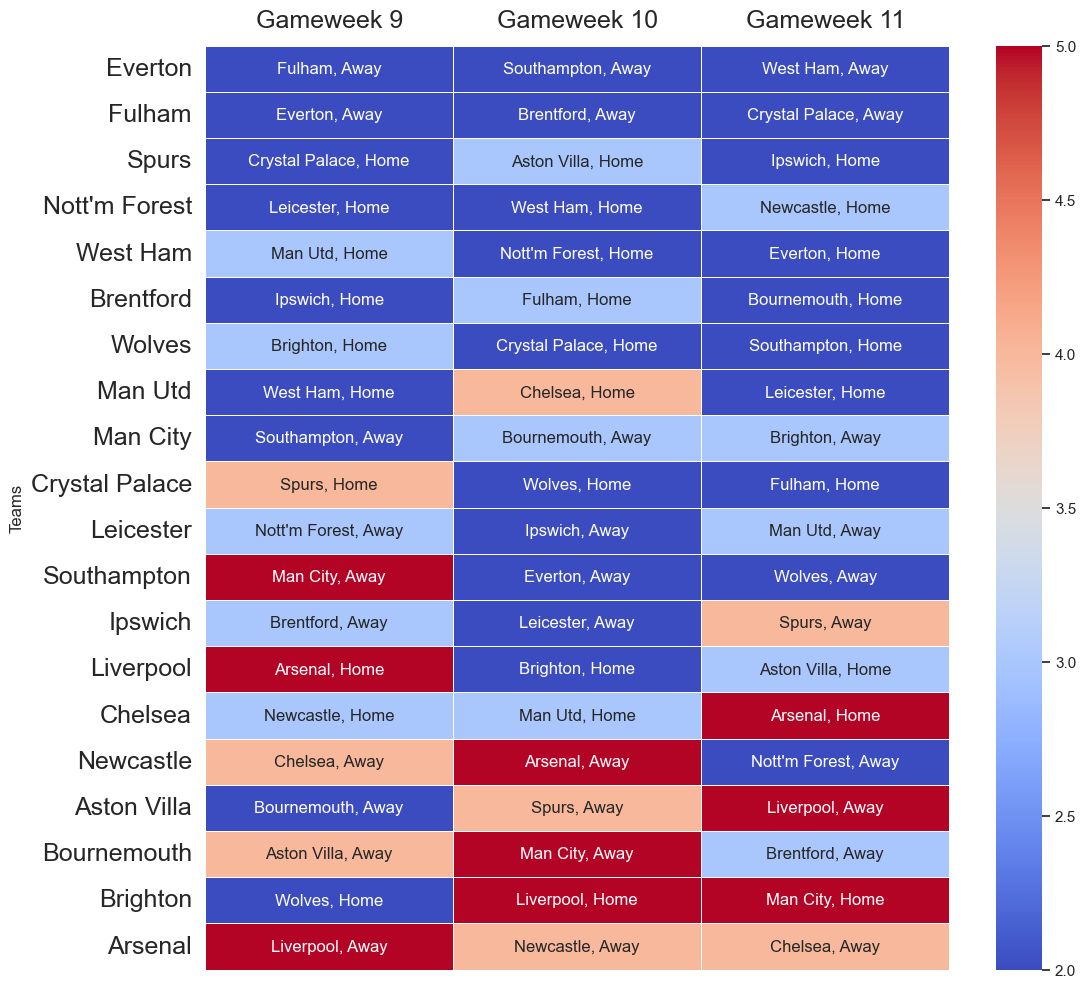

In [8]:
pl_teams = fixtures['team_h'].unique()
fixture_matrix_fdr = pd.DataFrame({'Teams': pl_teams})
fixture_matrix_fdr['next_5_fdr'] = fixture_matrix_fdr['Teams'].apply(lambda x: fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+3)['FDR'].mean())
fixture_matrix_fdr.sort_values(by='next_5_fdr', ascending=True, inplace=True)
fixture_matrix_fdr.drop('next_5_fdr', axis=1, inplace=True)

fixture_matrix_matches = fixture_matrix_fdr.copy()

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        fdr = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['FDR'].values[i-GAMEWEEKS_PLAYED]
        gw_fix.append(fdr)
    fixture_matrix_fdr['Gameweek {}'.format(i+1)] = gw_fix

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        opponent = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['opponent'].values[i-GAMEWEEKS_PLAYED]
        h_or_a = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['h_or_a'].values[-1]
        gw_fix.append('{}, {}'.format(opponent, h_or_a))
    fixture_matrix_matches['Gameweek {}'.format(i+1)] = gw_fix

fig, ax = plt.subplots(figsize=(12,12)) 
ax = sns.heatmap(fixture_matrix_fdr.set_index('Teams'), annot=fixture_matrix_matches.set_index('Teams'), fmt='', linewidth=.5, cmap='coolwarm')
plt.tick_params(axis='both', which='major', labelsize=18, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

In [9]:
fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', True, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
374,A.Becker,Liverpool,5.4,6.7,131,73.33,6.48,"[Arsenal, Away]",3.4,4,15,2,3.74,-1.74,35
95,Arrizabalaga,Bournemouth,4.5,0.8,65,62.50,3.78,"[Aston Villa, Away]",3.2,1,19,7,6.10,0.90,17
52,Martinez,Aston Villa,5.0,13.6,105,100.00,5.60,"[Bournemouth, Home]",3.4,1,20,10,8.67,1.33,28
595,Vicario,Spurs,5.0,3.7,124,100.00,4.60,"[Crystal Palace, Away]",2.8,2,17,9,8.68,0.32,23
517,Sels,Nott'm Forest,4.5,3.7,125,100.00,8.22,"[Leicester, Away]",2.8,3,26,6,8.70,-2.70,37
411,Ederson M.,Man City,5.5,8.8,81,100.00,4.18,"[Southampton, Home]",3.4,1,17,9,8.78,0.22,23
11,Raya,Arsenal,5.7,31.4,124,100.00,6.49,"[Liverpool, Home]",3.6,3,27,8,9.27,-1.27,37
209,Sánchez,Chelsea,4.7,11.9,151,100.00,8.09,"[Newcastle, Home]",3.2,2,36,10,9.66,0.34,38
291,Leno,Fulham,5.0,2.4,100,100.00,5.00,"[Everton, Away]",2.4,1,25,11,9.84,1.16,25
628,Johnstone,Wolves,4.4,0.5,31,62.50,2.27,"[Brighton, Away]",2.4,0,19,13,10.77,2.23,10


In [10]:
fpl.top_players(df, 'Defender', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
375,Alexander-Arnold,Liverpool,7.1,30.3,166,91.94,6.06,"[Arsenal, Away]",3.4,0,1,1,2.91,-1.91,0.39,5,3,5.17,-2.17,43
315,Davis,Ipswich,4.5,2.3,92,100.00,4.22,"[Brentford, Away]",2.8,0,1,1,1.89,-0.89,0.24,1,16,17.44,-1.44,19
583,Pedro Porro,Spurs,5.5,29.2,130,99.58,5.09,"[Crystal Palace, Away]",2.8,1,0,1,1.78,-0.78,0.22,2,9,8.62,0.38,28
23,Calafiori,Arsenal,5.8,2.3,60,53.33,2.41,"[Liverpool, Home]",3.6,1,0,1,0.91,0.09,0.22,0,6,4.97,1.03,14
398,Robertson,Liverpool,6.0,6.0,144,83.75,5.00,"[Arsenal, Away]",3.4,0,0,0,1.45,-1.45,0.22,4,3,5.20,-2.20,30
2,Gabriel,Arsenal,6.3,27.5,136,100.00,6.35,"[Liverpool, Home]",3.6,2,0,2,1.64,0.36,0.21,3,8,9.27,-1.27,40
629,Aït-Nouri,Wolves,4.4,3.8,45,90.83,5.23,"[Brighton, Away]",2.4,2,2,4,1.48,2.52,0.21,0,22,13.81,8.19,23
456,De Ligt,Man Utd,5.0,4.9,102,67.92,5.40,"[West Ham, Away]",2.4,1,0,1,1.14,-0.14,0.21,2,8,9.80,-1.80,27
486,Schär,Newcastle,5.4,1.1,55,66.25,2.78,"[Chelsea, Away]",3.0,1,0,1,1.15,-0.15,0.21,1,6,6.18,-0.18,15
102,Collins,Brentford,4.5,2.3,104,100.00,5.78,"[Ipswich, Home]",2.2,1,3,4,1.57,2.43,0.20,0,15,14.45,0.55,26


In [11]:
fpl.top_players(df, 'Defender', 'expected_goals_conceded', True, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
91,Smith,Bournemouth,4.5,0.2,55,51.53,3.33,"[Aston Villa, Away]",3.2,0,0,0,0.02,-0.02,0.00,1,3,3.85,-0.85,15
495,Alex Moreno,Nott'm Forest,4.4,0.6,61,50.69,3.64,"[Leicester, Away]",2.8,0,0,0,0.31,-0.31,0.08,2,4,4.69,-0.69,16
23,Calafiori,Arsenal,5.8,2.3,60,53.33,2.41,"[Liverpool, Home]",3.6,1,0,1,0.91,0.09,0.22,0,6,4.97,1.03,14
375,Alexander-Arnold,Liverpool,7.1,30.3,166,91.94,6.06,"[Arsenal, Away]",3.4,0,1,1,2.91,-1.91,0.39,5,3,5.17,-2.17,43
398,Robertson,Liverpool,6.0,6.0,144,83.75,5.00,"[Arsenal, Away]",3.4,0,0,0,1.45,-1.45,0.22,4,3,5.20,-2.20,30
389,Konaté,Liverpool,5.3,12.9,161,91.53,7.17,"[Arsenal, Away]",3.4,1,1,2,0.49,1.51,0.06,4,3,5.46,-2.46,38
5,J.Timber,Arsenal,5.5,1.4,77,62.22,3.45,"[Liverpool, Home]",3.6,0,1,1,0.45,0.55,0.09,2,4,5.56,-1.56,19
654,Mosquera,Wolves,4.0,0.7,24,61.25,0.75,"[Brighton, Away]",2.4,0,0,0,0.36,-0.36,0.08,0,12,5.63,6.37,3
163,Van Hecke,Brighton,4.5,0.6,93,63.75,4.44,"[Wolves, Home]",3.4,0,1,1,0.18,0.82,0.04,2,4,5.91,-1.91,20
401,Virgil,Liverpool,6.0,15.1,172,100.00,6.33,"[Arsenal, Away]",3.4,0,0,0,0.39,-0.39,0.05,5,3,5.95,-2.95,38


In [12]:
fpl.top_players(df, 'Midfielder', 'expected_goals_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
391,M.Salah,Liverpool,12.6,38.7,251,96.39,5.87,"[Arsenal, Away]",3.4,5,...,4.77,1.52,6.29,3.71,0.38,0.12,0.50,0.62,0.82,74
579,Johnson,Spurs,6.7,9.8,120,83.75,5.67,"[Crystal Palace, Away]",2.8,3,...,3.98,0.50,4.48,0.52,0.59,0.07,0.67,0.59,0.66,38
206,Palmer,Chelsea,10.9,52.2,287,95.14,6.33,"[Newcastle, Home]",3.2,6,...,4.45,1.96,6.41,4.59,0.41,0.18,0.59,0.58,0.84,69
390,Luis Díaz,Liverpool,7.9,29.9,188,65.28,6.96,"[Arsenal, Away]",3.4,5,...,2.89,0.75,3.64,2.36,0.37,0.09,0.46,0.55,0.69,55
380,Diogo J.,Liverpool,7.4,7.5,85,68.33,4.73,"[Arsenal, Away]",3.4,2,...,2.72,0.32,3.04,1.96,0.37,0.04,0.41,0.50,0.56,35
439,Garnacho,Man Utd,6.2,8.2,99,69.31,4.84,"[West Ham, Away]",2.4,2,...,2.77,0.42,3.19,-0.19,0.45,0.07,0.51,0.50,0.58,30
469,Gordon,Newcastle,7.3,10.0,128,94.86,4.25,"[Chelsea, Away]",3.0,2,...,3.47,1.38,4.85,-2.85,0.48,0.19,0.66,0.46,0.64,31
341,Buonanotte,Leicester,5.0,1.6,129,63.75,6.80,"[Nott'm Forest, Home]",3.0,3,...,2.03,0.77,2.80,2.20,0.41,0.15,0.56,0.40,0.55,34
614,Kudus,West Ham,6.3,3.6,101,91.94,3.65,"[Man Utd, Home]",3.2,2,...,2.83,0.86,3.69,-1.69,0.45,0.14,0.59,0.38,0.50,23
619,Souček,West Ham,5.0,2.8,96,71.81,5.60,"[Man Utd, Home]",3.2,2,...,2.11,0.54,2.65,0.35,0.42,0.11,0.53,0.37,0.46,28


In [13]:
fpl.top_players(df, 'Midfielder', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
582,Maddison,Spurs,7.6,6.8,202,84.44,5.66,"[Crystal Palace, Away]",2.8,2,...,2.10,3.57,5.67,0.33,0.28,0.47,0.75,0.31,0.84,43
206,Palmer,Chelsea,10.9,52.2,287,95.14,6.33,"[Newcastle, Home]",3.2,6,...,4.45,1.96,6.41,4.59,0.41,0.18,0.59,0.58,0.84,69
13,Saka,Arsenal,10.0,28.2,232,78.61,5.40,"[Liverpool, Home]",3.6,2,...,2.00,3.15,5.15,3.85,0.20,0.32,0.52,0.32,0.82,54
391,M.Salah,Liverpool,12.6,38.7,251,96.39,5.87,"[Arsenal, Away]",3.4,5,...,4.77,1.52,6.29,3.71,0.38,0.12,0.50,0.62,0.82,74
427,Sávio,Man City,6.5,1.6,96,50.42,3.08,"[Southampton, Home]",3.4,0,...,1.05,1.84,2.89,0.11,0.16,0.28,0.44,0.26,0.72,20
390,Luis Díaz,Liverpool,7.9,29.9,188,65.28,6.96,"[Arsenal, Away]",3.4,5,...,2.89,0.75,3.64,2.36,0.37,0.09,0.46,0.55,0.69,55
579,Johnson,Spurs,6.7,9.8,120,83.75,5.67,"[Crystal Palace, Away]",2.8,3,...,3.98,0.50,4.48,0.52,0.59,0.07,0.67,0.59,0.66,38
469,Gordon,Newcastle,7.3,10.0,128,94.86,4.25,"[Chelsea, Away]",3.0,2,...,3.47,1.38,4.85,-2.85,0.48,0.19,0.66,0.46,0.64,31
113,Mbeumo,Brentford,7.6,31.4,228,99.86,6.97,"[Ipswich, Home]",2.2,6,...,2.88,2.03,4.91,1.09,0.38,0.27,0.65,0.36,0.61,53
282,Adama,Fulham,5.1,3.8,127,86.53,5.88,"[Everton, Away]",2.4,1,...,2.45,1.72,4.17,-1.17,0.48,0.34,0.82,0.35,0.60,30


In [14]:
fpl.top_players(df, 'Midfielder', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
282,Adama,Fulham,5.1,3.8,127,86.53,5.88,"[Everton, Away]",2.4,1,...,2.45,1.72,4.17,-1.17,0.48,0.34,0.82,0.35,0.60,30
88,Semenyo,Bournemouth,5.6,8.7,117,96.81,5.89,"[Aston Villa, Away]",3.2,3,...,2.76,1.56,4.32,-0.32,0.49,0.28,0.77,0.36,0.56,33
582,Maddison,Spurs,7.6,6.8,202,84.44,5.66,"[Crystal Palace, Away]",2.8,2,...,2.10,3.57,5.67,0.33,0.28,0.47,0.75,0.31,0.84,43
283,Andreas,Fulham,5.3,1.8,109,84.86,4.34,"[Everton, Away]",2.4,1,...,1.89,1.74,3.63,-1.63,0.36,0.33,0.68,0.28,0.54,23
579,Johnson,Spurs,6.7,9.8,120,83.75,5.67,"[Crystal Palace, Away]",2.8,3,...,3.98,0.50,4.48,0.52,0.59,0.07,0.67,0.59,0.66,38
469,Gordon,Newcastle,7.3,10.0,128,94.86,4.25,"[Chelsea, Away]",3.0,2,...,3.47,1.38,4.85,-2.85,0.48,0.19,0.66,0.46,0.64,31
264,McNeil,Everton,5.8,11.9,208,98.89,8.10,"[Fulham, Home]",2.2,3,...,0.58,3.24,3.81,2.19,0.10,0.56,0.66,0.07,0.48,47
113,Mbeumo,Brentford,7.6,31.4,228,99.86,6.97,"[Ipswich, Home]",2.2,6,...,2.88,2.03,4.91,1.09,0.38,0.27,0.65,0.36,0.61,53
92,Tavernier,Bournemouth,5.5,0.4,106,92.08,4.91,"[Aston Villa, Away]",3.2,1,...,2.42,0.91,3.33,-1.33,0.44,0.17,0.61,0.33,0.45,27
614,Kudus,West Ham,6.3,3.6,101,91.94,3.65,"[Man Utd, Home]",3.2,2,...,2.83,0.86,3.69,-1.69,0.45,0.14,0.59,0.38,0.50,23


In [15]:
fpl.top_players(df, 'Forward', 'expected_goal_involvements', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
415,Haaland,Man City,15.4,73.5,323,99.86,4.48,"[Southampton, Home]",3.4,10,...,6.39,0.39,6.78,3.22,0.41,0.03,0.44,0.80,0.85,69
204,N.Jackson,Chelsea,7.9,17.1,196,84.86,6.08,"[Newcastle, Home]",3.2,5,...,5.25,0.23,5.48,2.52,0.66,0.03,0.69,0.77,0.80,48
3,Havertz,Arsenal,8.3,17.7,160,100.00,5.06,"[Liverpool, Home]",3.6,4,...,4.33,0.22,4.55,0.45,0.52,0.03,0.55,0.54,0.57,42
63,Watkins,Aston Villa,9.1,29.6,169,84.03,5.38,"[Bournemouth, Home]",3.4,5,...,3.97,0.33,4.30,2.70,0.44,0.04,0.47,0.59,0.64,49
167,Welbeck,Brighton,5.9,20.2,189,93.89,8.47,"[Wolves, Home]",3.4,5,...,3.92,0.30,4.22,1.78,0.66,0.05,0.72,0.52,0.56,50
565,Solanke,Spurs,7.7,13.4,90,73.19,2.99,"[Crystal Palace, Away]",2.8,2,...,3.53,0.58,4.11,-1.11,0.46,0.08,0.53,0.60,0.70,23
295,Raúl,Fulham,5.7,8.6,151,59.17,6.84,"[Everton, Away]",2.4,4,...,2.89,0.87,3.76,1.24,0.51,0.15,0.66,0.61,0.79,39
254,Calvert-Lewin,Everton,6.0,5.9,71,94.86,4.83,"[Fulham, Home]",2.2,2,...,3.24,0.44,3.68,-0.68,0.54,0.07,0.61,0.43,0.49,29
520,Wood,Nott'm Forest,6.3,14.0,167,88.89,7.30,"[Leicester, Away]",2.8,5,...,3.32,0.16,3.48,1.52,0.53,0.03,0.55,0.47,0.49,46
637,Cunha,Wolves,6.5,2.6,168,85.56,4.92,"[Brighton, Away]",2.4,3,...,1.97,1.27,3.24,-0.24,0.30,0.20,0.50,0.29,0.48,32


In [16]:
fpl.top_players(df, 'Forward', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
415,Haaland,Man City,15.4,73.5,323,99.86,4.48,"[Southampton, Home]",3.4,10,...,6.39,0.39,6.78,3.22,0.41,0.03,0.44,0.80,0.85,69
204,N.Jackson,Chelsea,7.9,17.1,196,84.86,6.08,"[Newcastle, Home]",3.2,5,...,5.25,0.23,5.48,2.52,0.66,0.03,0.69,0.77,0.80,48
295,Raúl,Fulham,5.7,8.6,151,59.17,6.84,"[Everton, Away]",2.4,4,...,2.89,0.87,3.76,1.24,0.51,0.15,0.66,0.61,0.79,39
565,Solanke,Spurs,7.7,13.4,90,73.19,2.99,"[Crystal Palace, Away]",2.8,2,...,3.53,0.58,4.11,-1.11,0.46,0.08,0.53,0.60,0.70,23
63,Watkins,Aston Villa,9.1,29.6,169,84.03,5.38,"[Bournemouth, Home]",3.4,5,...,3.97,0.33,4.30,2.70,0.44,0.04,0.47,0.59,0.64,49
454,Zirkzee,Man Utd,6.7,2.1,59,55.00,2.54,"[West Ham, Away]",2.4,1,...,2.44,0.33,2.77,-1.77,0.36,0.05,0.41,0.55,0.63,17
3,Havertz,Arsenal,8.3,17.7,160,100.00,5.06,"[Liverpool, Home]",3.6,4,...,4.33,0.22,4.55,0.45,0.52,0.03,0.55,0.54,0.57,42
167,Welbeck,Brighton,5.9,20.2,189,93.89,8.47,"[Wolves, Home]",3.4,5,...,3.92,0.30,4.22,1.78,0.66,0.05,0.72,0.52,0.56,50
99,Evanilson,Bournemouth,5.9,0.6,74,71.25,3.73,"[Aston Villa, Away]",3.2,1,...,2.50,0.59,3.09,-1.09,0.42,0.10,0.52,0.44,0.54,22
254,Calvert-Lewin,Everton,6.0,5.9,71,94.86,4.83,"[Fulham, Home]",2.2,2,...,3.24,0.44,3.68,-0.68,0.54,0.07,0.61,0.43,0.49,29


In [17]:
fpl.top_players(df, 'Forward', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
167,Welbeck,Brighton,5.9,20.2,189,93.89,8.47,"[Wolves, Home]",3.4,5,...,3.92,0.30,4.22,1.78,0.66,0.05,0.72,0.52,0.56,50
204,N.Jackson,Chelsea,7.9,17.1,196,84.86,6.08,"[Newcastle, Home]",3.2,5,...,5.25,0.23,5.48,2.52,0.66,0.03,0.69,0.77,0.80,48
295,Raúl,Fulham,5.7,8.6,151,59.17,6.84,"[Everton, Away]",2.4,4,...,2.89,0.87,3.76,1.24,0.51,0.15,0.66,0.61,0.79,39
254,Calvert-Lewin,Everton,6.0,5.9,71,94.86,4.83,"[Fulham, Home]",2.2,2,...,3.24,0.44,3.68,-0.68,0.54,0.07,0.61,0.43,0.49,29
3,Havertz,Arsenal,8.3,17.7,160,100.00,5.06,"[Liverpool, Home]",3.6,4,...,4.33,0.22,4.55,0.45,0.52,0.03,0.55,0.54,0.57,42
520,Wood,Nott'm Forest,6.3,14.0,167,88.89,7.30,"[Leicester, Away]",2.8,5,...,3.32,0.16,3.48,1.52,0.53,0.03,0.55,0.47,0.49,46
565,Solanke,Spurs,7.7,13.4,90,73.19,2.99,"[Crystal Palace, Away]",2.8,2,...,3.53,0.58,4.11,-1.11,0.46,0.08,0.53,0.60,0.70,23
365,Vardy,Leicester,5.7,11.1,109,92.08,5.26,"[Nott'm Forest, Home]",3.0,3,...,2.93,0.09,3.02,-0.02,0.51,0.02,0.53,0.40,0.41,30
99,Evanilson,Bournemouth,5.9,0.6,74,71.25,3.73,"[Aston Villa, Away]",3.2,1,...,2.50,0.59,3.09,-1.09,0.42,0.10,0.52,0.44,0.54,22
637,Cunha,Wolves,6.5,2.6,168,85.56,4.92,"[Brighton, Away]",2.4,3,...,1.97,1.27,3.24,-0.24,0.30,0.20,0.50,0.29,0.48,32


In [20]:
# try pulp optimizer
import pulp
metric = 'expected_goal_involvements_per_90'

x = pulp.LpVariable.dict("player", range(0, len(df)),
                        0,1, cat=pulp.LpInteger)
prob = pulp.LpProblem("FantasyFootball", pulp.LpMaximize)
prob += pulp.lpSum(df[metric].iloc[i] * x[i] for i in range(0, len(df)))
prob += sum(x[i] for i in range(0, len(df))) ==  11

prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Goalkeeper') == 1
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Defender') >= 3
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Defender') <= 5
 
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Midfielder') >= 3
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Midfielder') <= 5
 
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Forward') >= 1
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Forward') <= 3

prob += sum(x[i] * df["now_cost"].iloc[i] for i in range(0, len(df))) <= 83.3

print(prob.solve()) # Outputs 1 if successful
print(pulp.LpStatus[prob.status]) # Outputs "Optimal" if optimal
print(pulp.value(prob.objective)) # Shows us our points total

1
Optimal
6.499999999999999


In [21]:
for i in range(0, len(df)):
    if pulp.value(x[i]) == 1:
        print(df['web_name'].iloc[i])

Saka
N.Jackson
Palmer
Raúl
Davis
Alexander-Arnold
M.Salah
Sávio
Onana
Maddison
Pedro Porro
